In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import plotly.express as px
import re
from sklearn.model_selection import train_test_split

In [2]:
# I don't use the 'test' dataset for the EDA in order to not be influenced by it during my choices of preprocessing
df = pd.read_csv('train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
df.value_counts('target')/len(df)*100

target
0    57.034021
1    42.965979
dtype: float64

The dataset seems pretty balanced in terms of target distribution.

In [4]:
print(df['keyword'].unique())

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation' 'disaster' 'displaced' 'droug

Let's plot if there is a significant difference of distribution of the target between the tweets for which a keyword or localization information is missing : 

In [5]:
px.histogram(df, x = df['location'].isna(), y = 'target', histfunc = 'avg')

The fact that having the localization filled or not does not influence the target distribution.

In [6]:
print(df['location'].unique())

[nan 'Birmingham' 'Est. September 2012 - Bristol' ... 'Vancouver, Canada'
 'London ' 'Lincoln']


To prevent potential overfitting on the dataset, and considering a hypothesis that disasters may occur anywhere, i choose to not consider the location information in that study. 

In [7]:
df = df.drop(columns = ['location'])
df

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,Police investigating after an e-bike collided ...,1


In [8]:
px.histogram(df, x = df['keyword'].isna(), y = 'target', histfunc = 'avg')

The presence of a keyword seems to be associated with a positive-skewed distribution of the target, I'll keep that variable.

## Language Preprocessing

In [9]:
px.box(df['text'].str.len())

The lengths of the tweets are quite long (median = 107 characters), so i will not only rely on SimpleRNN to build the model architecture (they are not sufficiently robust on long string lengths). 

Because we're in a classification problem, lemmatizing and removing some stop_words will probably not be a bad thing. 

In [10]:
!python -m spacy download en_core_web_md -q

     |████████████████████████████████| 33.5 MB 170 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [11]:
import en_core_web_md
nlp = en_core_web_md.load()

In [12]:
from spacy.lang.en.stop_words import STOP_WORDS

In [131]:
# Remove all non alphanumeric characters except whitespaces
df["text_clean"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch in [" ", "#", "@"]))
# remove double spaces and spaces at the beginning and end of strings
df["text_clean"] = df["text_clean"].apply(lambda x: re.sub(" +"," ",x).lower().strip())
# remove stop words and replace everyword with their lemma
#df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
#df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

In [132]:
df["text"].apply(lambda x : [ch.isalnum() or ch == " " for ch in x])

0       [True, True, True, True, True, True, True, Tru...
1       [True, True, True, True, True, True, True, Tru...
2       [True, True, True, True, True, True, True, Tru...
3       [True, True, False, True, True, True, True, Tr...
4       [True, True, True, True, True, True, True, Tru...
                              ...                        
7608    [True, True, True, True, True, True, True, Tru...
7609    [False, True, True, True, True, False, True, T...
7610    [True, True, False, True, True, True, False, T...
7611    [True, True, True, True, True, True, True, Tru...
7612    [True, True, True, True, True, True, True, Tru...
Name: text, Length: 7613, dtype: object

In [133]:
df

,id,keyword,text,target,text_clean,text_encoded,len_text
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,"[107, 4475, 20, 1, 861, 5, 18, 239, 125, 1686,...",13
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[177, 42, 216, 673, 6783, 6784, 1341]",7
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[39, 1687, 1556, 4, 2067, 3, 646, 20, 120, 678...",22
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...,"[2799, 55, 4477, 1343, 245, 1342, 3, 85]",8
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,"[27, 90, 1163, 18, 316, 19, 6786, 2068, 25, 25...",16
...,...,...,...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,"[111, 812, 1310, 1034, 2, 340, 147, 65, 642, 1...",11
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ariaahrary @thetawniest the out of control wi...,"[6753, 6754, 1, 35, 5, 838, 271, 109, 3, 85, 1...",20
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...,"[3293, 4467, 6746, 219, 5, 570, 1545, 6747]",8
7611,10872,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,"[75, 1094, 37, 41, 3132, 314, 13, 2, 121, 3, 2...",19


In [200]:
num_words = 1000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, oov_token = '<OOV>')
tokenizer.fit_on_texts(df.text_clean)
df["text_encoded"] = tokenizer.texts_to_sequences(df.text_clean)

df["len_text"] = df["text_encoded"].apply(lambda x: len(x))
df = df[df["len_text"]!=0]

In [201]:
df

,id,keyword,text,target,text_clean,text_encoded,len_text
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",13
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[178, 43, 219, 678, 1, 1, 1]",7
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",22
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...,"[1, 56, 1, 1, 247, 1, 4, 86]",8
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",16
...,...,...,...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1]",11
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ariaahrary @thetawniest the out of control wi...,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",20
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...,"[1, 1, 1, 207, 6, 573, 1, 1]",8
7611,10872,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",19


In [202]:
px.box(df['len_text'])

In [203]:
len(tokenizer.index_word)

22866

In [204]:
df

,id,keyword,text,target,text_clean,text_encoded,len_text
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,"[109, 1, 21, 2, 865, 6, 19, 241, 126, 1, 1, 70...",13
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[178, 43, 219, 678, 1, 1, 1]",7
2,5,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[40, 1, 1, 5, 1, 4, 649, 21, 121, 1, 18, 1, 41...",22
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...,"[1, 56, 1, 1, 247, 1, 4, 86]",8
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,"[29, 92, 1, 19, 318, 20, 1, 1, 26, 255, 20, 1,...",16
...,...,...,...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,"[112, 817, 1, 1, 3, 342, 149, 66, 645, 194, 1]",11
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@ariaahrary @thetawniest the out of control wi...,"[1, 1, 2, 36, 6, 812, 261, 108, 4, 86, 157, 4,...",20
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m194 0104 utc5km s of volcano hawaii httptcozd...,"[1, 1, 1, 207, 6, 573, 1, 1]",8
7611,10872,NaN,Police investigating after an e-bike collided ...,1,police investigating after an ebike collided w...,"[76, 1, 38, 42, 1, 316, 14, 3, 122, 4, 260, 1,...",19


In [205]:
#train, val, y_train, y_val = train_test_split(df['text_encoded'], df['target'], random_state = 0, stratify = df['target'], test_size = 0.3)

In [206]:
text_encoded_padded = tf.keras.preprocessing.sequence.pad_sequences(df['text_encoded'], padding="post")

In [207]:
train, val, y_train, y_val = train_test_split(text_encoded_padded, df['target'], random_state = 0, stratify = df['target'], test_size = 0.3)

In [208]:
print(train.shape)
print(val.shape)

(5329, 31)
(2284, 31)


In [209]:
train_ds = tf.data.Dataset.from_tensor_slices((train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val, y_val))

train_ds = train_ds.shuffle(len(train_ds)).batch(128)
val_ds = val_ds.shuffle(len(val_ds)).batch(128)

In [210]:
embedding_dim=4 # the dimensionality of the representation space
#vocab_size = len(tokenizer.word_index) + 1
vocab_size = num_words 

model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding", input_length = (train.shape[-1])), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  #tf.keras.layers.LSTM(units=64, return_sequences=True), # maintains the sequential nature
  tf.keras.layers.LSTM(units=4, return_sequences=False), # returns the last output
  #tf.keras.layers.Dense(8, activation='relu'), # a dense layer
  tf.keras.layers.Dense(1, activation="sigmoid") # the prediction layer
])

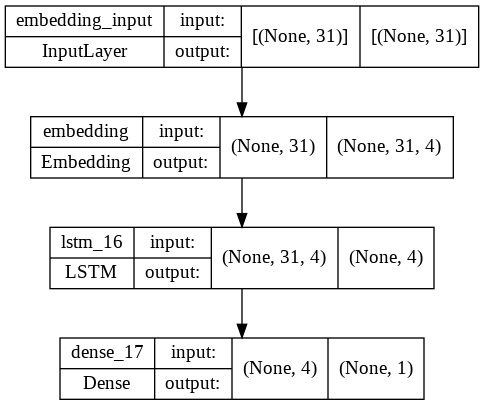

In [211]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [212]:
!pip install tensorflow-addons -q
import tensorflow_addons as tfa

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',tfa.metrics.F1Score(num_classes = 2, average = 'micro', threshold = 0.5)])

In [213]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20)

Epoch 1/20
42/42 [==============================] - 5s 58ms/step - loss: 0.6902 - accuracy: 0.5427 - f1_score: 0.2671 - val_loss: 0.6851 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 2/20
42/42 [==============================] - 1s 31ms/step - loss: 0.6839 - accuracy: 0.5703 - f1_score: 0.0000e+00 - val_loss: 0.6831 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 3/20
42/42 [==============================] - 1s 34ms/step - loss: 0.6831 - accuracy: 0.5703 - f1_score: 0.0000e+00 - val_loss: 0.6830 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 4/20
42/42 [==============================] - 1s 35ms/step - loss: 0.6828 - accuracy: 0.5703 - f1_score: 0.0000e+00 - val_loss: 0.6828 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 5/20
42/42 [==============================] - 2s 36ms/step - loss: 0.6824 - accuracy: 0.5703 - f1_score: 0.0000e+00 - val_loss: 0.6822 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 6/20
42/42 [==============================]

In [214]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=model.history.history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model.history.history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [215]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])

In [216]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=model.history.history["f1_score"],
                    mode='lines',
                    name='f1_score'))
fig.add_trace(go.Scatter(y=model.history.history["val_f1_score"],
                    mode='lines',
                    name='val_f1_score'))
fig.show()